## PICMUS beamforming with usbmd toolbox

In [1]:
from usbmd.ui import DataLoaderUI, setup
from usbmd.common import set_data_paths

In [2]:
## load a config file
config = setup(file='../../configs/config_picmus_rf.yaml')
config.plot.save = False

Using config file: ../../configs/config_picmus_rf.yaml


In [3]:
## setup data_root through users settings
config.data.user = set_data_paths('./users.yaml')
# user_info = {
#     'myusername': {
#         'hostname': {
#             'data_root': 'C:/path_to_my_data_root/'}}
# }
# set_data_paths(user_info)
# or load from yaml file, users.yaml

c:\users\s154329\projects\ultrasound-bmd\usbmd\common.py:98: UserWarning: Cannot find user file: users.yaml.
 falling back to default path
  warnings.warn(f'Cannot find user file: {config_path}.\n falling back to default path')
c:\users\s154329\projects\ultrasound-bmd\usbmd\common.py:139: UserWarning: Unknown user s154329 in user file.
 falling back to default path. Please update the `./users.yaml` file with your data-path settings.
  warnings.warn(f'Unknown user {username} in user file.\n falling back to default path. '\


### PICMUS

### Experiments - resolution distortion

#### RF beamforming

Using tensorflow library for processing
Selected Z:\Ultrasound-BMd\data\PICMUS\database\experiments\resolution_distorsion\resolution_distorsion_expe_dataset_rf.hdf5


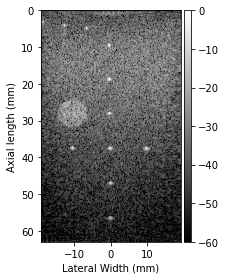

In [4]:
config.data.file_path = 'PICMUS/database/experiments/resolution_distorsion/resolution_distorsion_expe_dataset_rf.hdf5'
config.data.dataset_name = 'picmus'
config.data.subset = 'experiments/resolution_distorsion'
# The modulation type data is saved in ('rf', 'iq')
config.data.from_modtype = 'rf'
# The modulation type we would like to process the data with
config.data.modtype = 'rf'

# After removing the carrier of the rf signal, we can decimate the data with factor 4
config.scan.downsample = 1

ui = DataLoaderUI(config)
image = ui.run()

#### IQ beamforming

Using tensorflow library for processing
Selected Z:\Ultrasound-BMd\data\PICMUS\database\experiments\resolution_distorsion\resolution_distorsion_expe_dataset_iq.hdf5


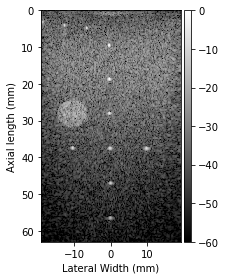

In [5]:
config.data.file_path = 'PICMUS/database/experiments/resolution_distorsion/resolution_distorsion_expe_dataset_iq.hdf5'
config.data.dataset_name = 'picmus'
config.data.subset = 'experiments/resolution_distorsion'
# The modulation type data is saved in ('rf', 'iq')
config.data.from_modtype = 'iq'
# The modulation type we would like to process the data with
config.data.modtype = 'iq'

# IQ data is decimated with factor 4
config.scan.downsample = 4
sampling_freq_rf = ui.scan.fs
sampling_freq_iq = ui.scan.fs / config.scan.downsample
config.scan.fs = sampling_freq_iq
ui = DataLoaderUI(config)
image = ui.run()

#### IQ beamforming, but reading RF data

Using tensorflow library for processing
Selected Z:\Ultrasound-BMd\data\PICMUS\database\experiments\resolution_distorsion\resolution_distorsion_expe_dataset_rf.hdf5


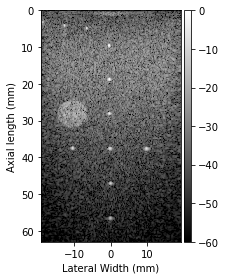

In [11]:
config.data.file_path = 'PICMUS/database/experiments/resolution_distorsion/resolution_distorsion_expe_dataset_rf.hdf5'
config.data.dataset_name = 'picmus'
config.data.subset = 'experiments/resolution_distorsion'
# The modulation type data is saved in ('rf', 'iq')
config.data.from_modtype = 'rf'
# The modulation type we would like to process the data with <--- this is now changed to IQ
config.data.modtype = 'iq'

config.scan.downsample = 1
config.scan.fs = sampling_freq_rf

ui = DataLoaderUI(config)
image = ui.run()

#### RF beamforming, but reading IQ data

In [15]:
config.data.file_path = 'PICMUS/database/experiments/resolution_distorsion/resolution_distorsion_expe_dataset_iq.hdf5'
config.data.dataset_name = 'picmus'
config.data.subset = 'experiments/resolution_distorsion'
# The modulation type data is saved in ('rf', 'iq')
config.data.from_modtype = 'iq'
# The modulation type we would like to process the data with <--- this is now changed to IQ
config.data.modtype = 'rf'

config.scan.downsample = 1
config.scan.fs = sampling_freq_rf

ui = DataLoaderUI(config)
image = ui.run()

Using tensorflow library for processing
Selected Z:\Ultrasound-BMd\data\PICMUS\database\experiments\resolution_distorsion\resolution_distorsion_expe_dataset_iq.hdf5


ValueError: Input 0 is incompatible with layer model_11: expected shape=(None, 11, 128, 832, 1), found shape=(1, 11, 128, 3328, 1)

### Simulations - resolution distortion

#### RF beamforming

In [7]:
config.data.file_path = 'PICMUS/database/simulation/resolution_distorsion/resolution_distorsion_simu_dataset_rf.hdf5'
config.data.dataset_name = 'picmus'
config.data.subset = 'simulation/resolution_distorsion'
# The modulation type data is saved in ('rf', 'iq')
config.data.from_modtype = 'rf'
# The modulation type we would like to process the data with
config.data.modtype = 'rf'

# RF signal is not decimated
config.scan.downsample = 4
config.scan.fs = sampling_freq_rf

ui = DataLoaderUI(config)
image = ui.run()

Using tensorflow library for processing
Selected Z:\Ultrasound-BMd\data\PICMUS\database\simulation\resolution_distorsion\resolution_distorsion_simu_dataset_rf.hdf5


ValueError: Input 0 is incompatible with layer model_3: expected shape=(None, 11, 128, 381, 1), found shape=(1, 11, 128, 1527, 1)

#### IQ beamforming

In [ ]:

config.data.file_path = 'PICMUS/database/simulation/resolution_distorsion/resolution_distorsion_simu_dataset_iq.hdf5'
config.data.dataset_name = 'picmus'
config.data.subset = 'simulation/resolution_distorsion'
# The modulation type data is saved in ('rf', 'iq')
config.data.from_modtype = 'iq'
# The modulation type we would like to process the data with
config.data.modtype = 'iq'

# IQ data is decimated with factor 4
config.scan.downsample = 4
config.scan.fs = sampling_freq_iq
config.scan.N_ax = 1528 
# 1527 is the number of axial samples in the rf simulation dataset, had to do +1 since that results in number
# of samples of IQ dataset 328. this is a quirk of the PICMUS dataset

ui = DataLoaderUI(config)
image = ui.run()